In [2]:
# Imports
import pandas as pd
import itertools
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier, MLPRegressor
import utils
import tensorflow_probability as tfp
import tensorflow as tf
import torch as tr

In [3]:
# Helpers
def openness_dict(file):
    df = pd.read_csv(file)
    out_dict = {}
    for i, row in df.iterrows():
        gene_id = row['gene_id']
        a_t = row['A_g_sum']
        out_dict[gene_id] = a_t
    return out_dict

# Requires rep[1-3]_[48|72] dictionaries to be defined
def prune_by_openness():
    gene_ids = list(rep1_48.keys())
    for gene in gene_ids:
        if rep1_48[gene] == 0 and rep2_48[gene] == 0 and rep3_48[gene] == 0 and rep1_72[gene] == 0 and rep2_72[gene] == 0 and rep3_72[gene] == 0:
            del rep1_48[gene]
            del rep2_48[gene]
            del rep3_48[gene]
            del rep1_72[gene]
            del rep2_72[gene]
            del rep3_72[gene]
            
# Requires rep[1-3]_[48|72] and promoters dictionaries to be defined
def prune_by_promoters():
    for gene in list(rep1_48.keys()):
        if gene not in gene_ids:
            del rep1_48[gene]
            del rep2_48[gene]
            del rep3_48[gene]
            del rep1_72[gene]
            del rep2_72[gene]
            del rep3_72[gene]

def promoter_dict(fbgns):
    df = pd.read_csv('linear_regression_promoters.csv')
    out_dict = {}
    for fbgn in tqdm(fbgns):
        try:
            out_dict[fbgn] = df[df['gene_id'] == fbgn].iloc[0]['sequence'] #promoter_seq
        except:
            continue
    return out_dict

def aggregate_openness_scores(rep, components):
    rep_avg = []
    rep_sum = []
    for component in components:
        o_scores = [rep[fbgn] if fbgn in rep.keys() else 0 for fbgn in component]
        summation = sum(o_scores)
        average = summation/len(o_scores)
        rep_avg.append(average)
        rep_sum.append(summation)
    return rep_avg, rep_sum

In [4]:
# Load openness data
rep1_48 = openness_dict('Openness output/500promoter500gene_48hr_rep1.csv')
rep2_48 = openness_dict('Openness output/500promoter500gene_48hr_rep2.csv')
rep3_48 = openness_dict('Openness output/500promoter500gene_48hr_rep3.csv')
rep1_72 = openness_dict('Openness output/500promoter500gene_72hr_rep1.csv')
rep2_72 = openness_dict('Openness output/500promoter500gene_72hr_rep2.csv')
rep3_72 = openness_dict('Openness output/500promoter500gene_72hr_rep3.csv')
prune_by_openness() 
gene_ids = list(rep1_48.keys())

In [5]:
# Load promoter data
promoters = promoter_dict(gene_ids) # {FBgn: promoter sequence}
gene_ids = list(promoters.keys())
prune_by_promoters()

100%|██████████| 1433/1433 [00:01<00:00, 1395.14it/s]


In [6]:
# Accessibility (normalized openness score) for each gene at time step t for each replication
at_r1 = list(rep1_48.values())
at_r2 = list(rep2_48.values())
at_r3 = list(rep3_48.values())

# Accessibility for each gene at t+1 for each replication (combined)
y = [a_g for rep in [rep1_72, rep2_72, rep3_72] for a_g in rep.values()]
y_direction = [1 if y[i]-x > 0 else 0 for i, x in enumerate(at_r1+at_r2+at_r3)]

# A matrix of promoters in one-hot vector representation. Assumes each promoter is 60 bases long.
P = np.stack([utils.seq_to_vec(seq) for seq in promoters.values()])

# Dot product of accessibility and promoter sequences
# A measure of how strongly each base at each position is associated with openness within the environment
atP_r1 = np.dot(at_r1, P)
atP_r2 = np.dot(at_r2, P)
atP_r3 = np.dot(at_r3, P)

In [6]:
# Construct x by appending the environment information atP_r[1-3] with each gene's promoter one-hot vector
# We process all the genes in each replication as a batch to keep them in order
x = []
for rep in [atP_r1, atP_r2, atP_r3]:
    for gene in gene_ids:
        vec = utils.seq_to_vec(promoters[gene])
        x.append(np.append(rep, vec))

In [7]:
# Sanity check for vector/matrix shapes
P.shape, atP_r1.shape, np.stack(x).shape, len(y)

((607, 240), (240,), (1821, 480), 1821)

In [8]:
# Sanity check for matching up the ordering of genes in x and y
gene_ids == list(rep1_48.keys()) == list(rep1_72.keys()) == list(rep2_48.keys()) == list(rep2_72.keys()) == list(rep3_48.keys()) == list(rep3_72.keys())

True

# Model 1

In [211]:
# Do linear regression
result = np.linalg.lstsq(x, y, rcond=None)[0]
result.shape

(480,)

In [212]:
# Calculate sum squared error, mean squared error
sum_sq_err = 0
for i in range(len(y)):
    pred = np.dot(x[i], result)
    sq_err = (y[i] - pred)**2
    sum_sq_err += sq_err
sum_sq_err, sum_sq_err/len(y)

(0.00014848078162238424, 8.153804592113358e-08)

sum of squared error: 5.5325150966149795e-05
mean squared error: 9.114522399695189e-08
max squared error: 3.2643416997500155e-06
mean, min, max relative error: 11.443764739787188 0.005832098265878133 64.49497826713385
direction accuracy: 0.47775947281713343


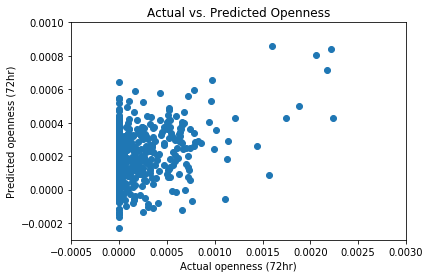

In [230]:
# Hold out rep3 to test the model on
train_len = len(rep1_48) + len(rep2_48)
train_x, test_x = x[:train_len], x[train_len:]
train_y, test_y = y[:train_len], y[train_len:]
theta = np.linalg.lstsq(train_x, train_y, rcond=None)[0]

preds = []
sq_errs = []
relative_errs = []
correct_direction = []
for i in range(len(test_y)):
    pred = np.dot(test_x[i], theta)
    preds.append(pred)
    sq_err = (test_y[i] - pred)**2
    sq_errs.append(sq_err)
    relative_err = abs((test_y[i] - pred))/test_y[i] if test_y[i] > 0 else abs((test_y[i] - pred))/(1e-5)
    relative_errs.append(relative_err)
    actual_direction = (test_y[i] - at_r3[i]) > 0
    pred_direction = (pred - at_r3[i]) > 0
    correct_direction.append(1 if actual_direction == pred_direction else 0)

plt.xlabel('Actual openness (72hr)')
plt.ylabel('Predicted openness (72hr)')
plt.title('Actual vs. Predicted Openness')
plt.xlim([-0.0005, 0.003])
plt.ylim([-0.0003, 0.001])
plt.scatter(test_y, preds)
print('sum of squared error:', sum(sq_errs))
print('mean squared error:', sum(sq_errs)/len(test_y))
print('max squared error:', max(sq_errs))
print('mean, min, max relative error:', sum(relative_errs)/len(test_y), min(relative_errs), max(relative_errs)) # Relative to the actual value
print('direction accuracy:', sum(correct_direction)/len(test_y))

## Linear model with bias

sum of squared error: 5.5325150966149795e-05
mean squared error: 9.114522399695189e-08
mean, min, max relative error: 11.443764739787188 0.005832098265878133 64.49497826713385
direction accuracy: 0.47775947281713343


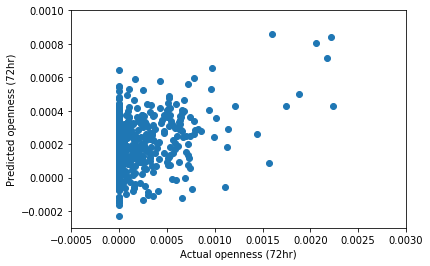

In [13]:
x = []
for rep in [atP_r1, atP_r2, atP_r3]:
    for gene in gene_ids:
        vec = utils.seq_to_vec(promoters[gene])
        x.append(np.append(rep, vec+[1]))
        
train_len = len(rep1_48) + len(rep2_48)
train_x, test_x = x[:train_len], x[train_len:]
train_y, test_y = y[:train_len], y[train_len:]
theta = np.linalg.lstsq(train_x, train_y, rcond=None)[0]

preds = []
sq_errs = []
relative_errs = []
correct_direction = []
for i in range(len(test_y)):
    pred = np.dot(test_x[i], theta)
    preds.append(pred)
    sq_err = (test_y[i] - pred)**2
    sq_errs.append(sq_err)
    relative_err = abs((test_y[i] - pred))/test_y[i] if test_y[i] > 0 else abs((test_y[i] - pred))/(1e-5)
    relative_errs.append(relative_err)
    actual_direction = (test_y[i] - at_r3[i]) > 0
    pred_direction = (pred - at_r3[i]) > 0
    correct_direction.append(1 if actual_direction == pred_direction else 0)

plt.xlabel('Actual openness (72hr)')
plt.ylabel('Predicted openness (72hr)')
plt.xlim([-0.0005, 0.003])
plt.ylim([-0.0003, 0.001])
plt.scatter(test_y, preds)
print('sum of squared error:', sum(sq_errs))
print('mean squared error:', sum(sq_errs)/len(test_y))
print('mean, min, max relative error:', sum(relative_errs)/len(test_y), min(relative_errs), max(relative_errs)) # Relative to the actual value
print('direction accuracy:', sum(correct_direction)/len(test_y))

## Linear model - x vector weighted by openness of gene

sum of squared error: 5.492776400981055e-05
mean squared error: 9.049055026327932e-08
mean, min, max relative error: 10.873460842954835 0.0064115568650360685 63.29493134350984
direction accuracy: 0.4827018121911038


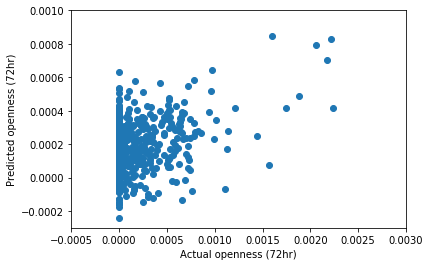

In [214]:
x = []
for rep in [atP_r1, atP_r2, atP_r3]:
    for gene in gene_ids:
        vec = utils.seq_to_vec(promoters[gene])
        x.append(vec) # Only promoter of interest note: there will be multiple (3) y for a single x!
        #x.append([vec[i]*rep[i] for i in range(len(vec))]) # Only promoter of interest element-wise multiplied with env
        #x.append(np.append(rep, [vec[i]*rep[i] for i in range(len(vec))])) # env, promoter of interest, element-wise multiply

train_len = len(rep1_48) + len(rep2_48)
train_x, test_x = x[:train_len], x[train_len:]
train_y, test_y = y[:train_len], y[train_len:]
theta = np.linalg.lstsq(train_x, train_y, rcond=None)[0]

preds = []
sq_errs = []
relative_errs = []
correct_direction = []
for i in range(len(test_y)):
    pred = np.dot(test_x[i], theta)
    preds.append(pred)
    sq_err = (test_y[i] - pred)**2
    sq_errs.append(sq_err)
    relative_err = abs((test_y[i] - pred))/test_y[i] if test_y[i] > 0 else abs((test_y[i] - pred))/(1e-5)
    relative_errs.append(relative_err)
    actual_direction = (test_y[i] - at_r3[i]) > 0
    pred_direction = (pred - at_r3[i]) > 0
    correct_direction.append(1 if actual_direction == pred_direction else 0)

plt.xlabel('Actual openness (72hr)')
plt.ylabel('Predicted openness (72hr)')
plt.xlim([-0.0005, 0.003])
plt.ylim([-0.0003, 0.001])
plt.scatter(test_y, preds)
print('sum of squared error:', sum(sq_errs))
print('mean squared error:', sum(sq_errs)/len(test_y))
print('mean, min, max relative error:', sum(relative_errs)/len(test_y), min(relative_errs), max(relative_errs)) # Relative to the actual value
print('direction accuracy:', sum(correct_direction)/len(test_y))

## Linear model - spread promoter vector

sum of squared error: 5.1478864055850894e-05
mean squared error: 8.480867225016622e-08
mean, min, max relative error: 10.574052367755513 0.009278925672262517 63.632637044630506
direction accuracy: 0.4975288303130148


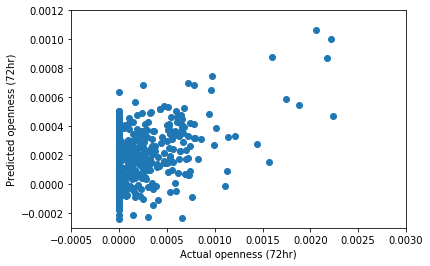

In [215]:
x = []
for rep in [atP_r1, atP_r2, atP_r3]:
    for gene in gene_ids:
        vec = utils.seq_to_vec(promoters[gene])
        vec = utils.spread_vec(vec)
        x.append(vec) # Only promoter of interest note: there will be multiple (3) y for a single x!
        #x.append([vec[i]*rep[i] for i in range(len(vec))]) # Only promoter of interest element-wise multiplied with env
        #x.append(np.append(rep, [vec[i]*rep[i] for i in range(len(vec))])) # env, promoter of interest, element-wise multiply

train_len = len(rep1_48) + len(rep2_48)
train_x, test_x = x[:train_len], x[train_len:]
train_y, test_y = y[:train_len], y[train_len:]
theta = np.linalg.lstsq(train_x, train_y, rcond=None)[0]

preds = []
sq_errs = []
relative_errs = []
correct_direction = []
for i in range(len(test_y)):
    pred = np.dot(test_x[i], theta)
    preds.append(pred)
    sq_err = (test_y[i] - pred)**2
    sq_errs.append(sq_err)
    relative_err = abs((test_y[i] - pred))/test_y[i] if test_y[i] > 0 else abs((test_y[i] - pred))/(1e-5)
    relative_errs.append(relative_err)
    actual_direction = (test_y[i] - at_r3[i]) > 0
    pred_direction = (pred - at_r3[i]) > 0
    correct_direction.append(1 if actual_direction == pred_direction else 0)

plt.xlabel('Actual openness (72hr)')
plt.ylabel('Predicted openness (72hr)')
plt.xlim([-0.0005, 0.003])
plt.ylim([-0.0003, 0.0012])
plt.scatter(test_y, preds)
print('sum of squared error:', sum(sq_errs))
print('mean squared error:', sum(sq_errs)/len(test_y))
print('mean, min, max relative error:', sum(relative_errs)/len(test_y), min(relative_errs), max(relative_errs)) # Relative to the actual value
print('direction accuracy:', sum(correct_direction)/len(test_y))

# Toggle input variations

In [111]:
x = []
for rep in [atP_r1, atP_r2, atP_r3]:
    for gene in gene_ids:
        vec = utils.seq_to_vec(promoters[gene])
        vec = utils.spread_vec(vec)
        x.append(np.append(rep, vec)) # Original
        #x.append(vec) # Only promoter of interest note: there will be multiple (3) y for a single x! TODO: fix this
        #x.append([vec[i]*rep[i] for i in range(len(vec))]) # Only promoter of interest element-wise multiplied with env
        #x.append(np.append(rep, [vec[i]*rep[i] for i in range(len(vec))])) # env, promoter of interest, element-wise multiply

# SVC

In [112]:
# Using direction of change in openness as class
train_len = len(rep1_48) + len(rep2_48)
train_x, test_x = x[:train_len], x[train_len:]
train_y, test_y = y_direction[:train_len], y_direction[train_len:]

clf = svm.SVC(gamma='scale')
clf.fit(train_x, train_y)

pred_y = [clf.predict(np.array(x).reshape(1, -1)) for x in test_x]
confusion_matrix(test_y, pred_y), sum(test_y)

(array([[389,  51],
        [141,  26]]),
 167)

# SVR

In [99]:
train_len = len(rep1_48) + len(rep2_48)
train_x, test_x = x[:train_len], x[train_len:]
train_y, test_y = y[:train_len], y[train_len:]

clf = svm.SVR(kernel='poly', degree=8, gamma='scale', C=100)
clf.fit(train_x, train_y)

SVR(C=100, cache_size=200, coef0=0.0, degree=8, epsilon=0.1, gamma='scale',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

sum of squared error: 0.0012823311877500003
mean squared error: 2.1125719732289955e-06
mean, min, max relative error: 94.12520036840475 0.010910224438904192 197.31249999999972
direction accuracy: 0.2981878088962109


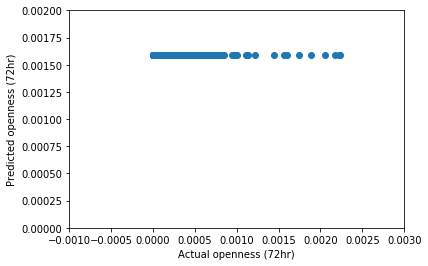

In [100]:
preds = [clf.predict(np.array(x).reshape(1, -1))[0] for x in test_x]
sq_errs = []
relative_errs = []
correct_direction = []
for i in range(len(test_y)):
    pred = preds[i]
    sq_err = (test_y[i] - pred)**2
    sq_errs.append(sq_err)
    relative_err = abs((test_y[i] - pred))/test_y[i] if test_y[i] > 0 else abs((test_y[i] - pred))/(1e-5)
    relative_errs.append(relative_err)
    actual_direction = (test_y[i] - at_r3[i]) > 0
    pred_direction = (pred - at_r3[i]) > 0
    correct_direction.append(1 if actual_direction == pred_direction else 0)

plt.xlabel('Actual openness (72hr)')
plt.ylabel('Predicted openness (72hr)')
plt.xlim([-0.001, 0.003])
plt.ylim([0, 0.002])
plt.scatter(test_y, preds)
print('sum of squared error:', sum(sq_errs))
print('mean squared error:', sum(sq_errs)/len(test_y))
print('mean, min, max relative error:', sum(relative_errs)/len(test_y), min(relative_errs), max(relative_errs)) # Relative to the actual value
print('direction accuracy:', sum(correct_direction)/len(test_y))

In [72]:
mean_sq_err = []
mean_relative_err = []
direction_accuracy = []
degree = range(1, 101)
for i in tqdm(degree):
    clf = svm.SVR(kernel='poly', gamma='scale', degree=i)
    clf.fit(train_x, train_y)
    preds = [clf.predict(np.array(x).reshape(1, -1))[0] for x in test_x]
    sq_errs = []
    relative_errs = []
    correct_direction = []
    for i in range(len(test_y)):
        pred = preds[i]
        sq_err = (test_y[i] - pred)**2
        sq_errs.append(sq_err)
        relative_err = abs((test_y[i] - pred))/test_y[i] if test_y[i] > 0 else abs((test_y[i] - pred))/(1e-5)
        relative_errs.append(relative_err)
        actual_direction = (test_y[i] - at_r3[i]) > 0
        pred_direction = (pred - at_r3[i]) > 0
        correct_direction.append(1 if actual_direction == pred_direction else 0)
    mean_sq_err.append(sum(sq_errs)/len(test_y))
    mean_relative_err.append(sum(relative_errs)/len(test_y))
    direction_accuracy.append(sum(correct_direction)/len(test_y))

100%|██████████| 100/100 [00:04<00:00, 20.04it/s]


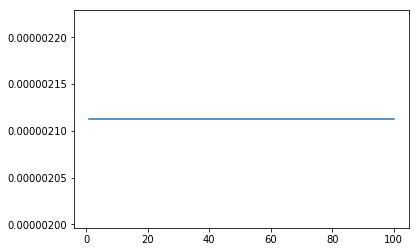

In [73]:
plt.plot(degree, mean_sq_err)

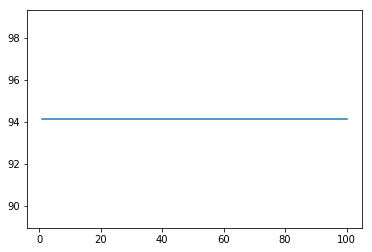

In [74]:
plt.plot(degree, mean_relative_err)

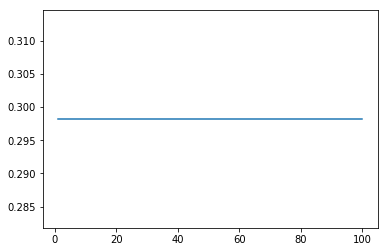

In [75]:
plt.plot(degree, direction_accuracy)

# MLP Classifier

In [104]:
train_len = len(rep1_48) + len(rep2_48)
train_x, test_x = x[:train_len], x[train_len:]
train_y, test_y = y_direction[:train_len], y_direction[train_len:]

clf = MLPClassifier([10, 5])
clf.fit(train_x, train_y)
pred_y = [clf.predict(np.array(x).reshape(1, -1)) for x in test_x]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [105]:
cm = confusion_matrix(test_y, pred_y)
cm, (cm[0][0]+cm[1][1])/len(test_y)

(array([[230, 210],
        [ 86,  81]]),
 0.5123558484349259)

# MLP Regressor

sum of squared error: 0.7562731469309287
mean squared error: 0.0012459195171843965
mean, min, max relative error: 1749.3769046668717 0.09837758114523719 11323.094031105102
direction accuracy: 0.5123558484349259


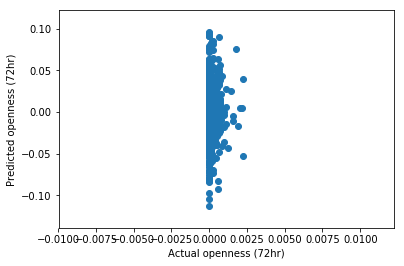

In [124]:
train_len = len(rep1_48) + len(rep2_48)
train_x, test_x = x[:train_len], x[train_len:]
train_y, test_y = y[:train_len], y[train_len:]

clf = MLPRegressor([10, 5, 3], activation='relu')
clf.fit(train_x, train_y)

preds = [clf.predict(np.array(x).reshape(1, -1))[0] for x in test_x]
sq_errs = []
relative_errs = []
correct_direction = []
for i in range(len(test_y)):
    pred = preds[i]
    sq_err = (test_y[i] - pred)**2
    sq_errs.append(sq_err)
    relative_err = abs((test_y[i] - pred))/test_y[i] if test_y[i] > 0 else abs((test_y[i] - pred))/(1e-5)
    relative_errs.append(relative_err)
    actual_direction = (test_y[i] - at_r3[i]) > 0
    pred_direction = (pred - at_r3[i]) > 0
    correct_direction.append(1 if actual_direction == pred_direction else 0)

plt.xlabel('Actual openness (72hr)')
plt.ylabel('Predicted openness (72hr)')
# plt.xlim([-0.001, 0.001])
# plt.ylim([-0.01, 0.01])
plt.scatter(test_y, preds)
print('sum of squared error:', sum(sq_errs))
print('mean squared error:', sum(sq_errs)/len(test_y))
print('mean, min, max relative error:', sum(relative_errs)/len(test_y), min(relative_errs), max(relative_errs)) # Relative to the actual value
print('direction accuracy:', sum(correct_direction)/len(test_y))

# Linear promoter model with softplus

sum of squared error: 6.833779545238466e-05
mean squared error: 1.1258285906488411e-07
mean, min, max relative error: 1.650131051605487 0.0035685302774347183 24.14287778432537
direction accuracy: 0.5205930807248764


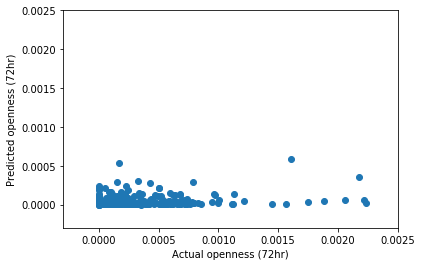

In [221]:
x = []
for rep in [atP_r1, atP_r2, atP_r3]:
    for gene in gene_ids:
        vec = utils.seq_to_vec(promoters[gene])
        #vec = utils.spread_vec(vec)
        x.append(np.append(rep*10, vec+[1]))
        #x.append(vec) # Only promoter of interest note: there will be multiple (3) y for a single x!
        #x.append([vec[i]*rep[i] for i in range(len(vec))]) # Only promoter of interest element-wise multiplied with env
        #x.append(np.append(rep, np.append(vec, [vec[i]*rep[i] for i in range(len(vec))]))) # env, promoter of interest, element-wise multiply

y_spinv = [float(tfp.math.softplus_inverse((100*Y)+(4.518e-5))) for Y in y]
        
train_len = len(rep1_48) + len(rep2_48)
train_x, test_x = x[:train_len], x[train_len:]
train_y, test_y = y_spinv[:train_len], y[train_len:]
theta = np.linalg.lstsq(train_x, train_y, rcond=None)[0]

preds = []
sq_errs = []
relative_errs = []
correct_direction = []
for i in range(len(test_y)):
    pred = np.dot(test_x[i], theta)
    #pred = abs(float(tf.math.softplus(pred))-1) # taking absolute value or reLU doesn't change performance
    pred = (float((tf.math.softplus(pred)))-(4.518e-5))/100
    preds.append(pred)
    sq_err = (test_y[i] - pred)**2
    sq_errs.append(sq_err)
    relative_err = abs((test_y[i] - pred))/test_y[i] if test_y[i] > 0 else abs((test_y[i] - pred))/(1e-5)
    relative_errs.append(relative_err)
    actual_direction = (test_y[i] - at_r3[i]) > 0
    pred_direction = (pred - at_r3[i]) > 0
    correct_direction.append(1 if actual_direction == pred_direction else 0)

plt.xlabel('Actual openness (72hr)')
plt.ylabel('Predicted openness (72hr)')
plt.xlim([-0.0003, 0.0025])
plt.ylim([-0.0003, 0.0025])
plt.scatter(test_y, preds)
print('sum of squared error:', sum(sq_errs))
print('mean squared error:', sum(sq_errs)/len(test_y))
print('mean, min, max relative error:', sum(relative_errs)/len(test_y), min(relative_errs), max(relative_errs)) # Relative to the actual value
print('direction accuracy:', sum(correct_direction)/len(test_y))

# Gradient Descent with softplus

In [228]:
# Training

# Prepare input
x = []
for rep in [atP_r1, atP_r2, atP_r3]:
    for gene in gene_ids:
        vec = utils.seq_to_vec(promoters[gene])
        #vec = utils.spread_vec(vec)
        x.append(np.append(rep*10, vec+[1]))
        #x.append(vec) # Only promoter of interest note: there will be multiple (3) y for a single x!
        #x.append([vec[i]*rep[i] for i in range(len(vec))]) # Only promoter of interest element-wise multiplied with env
        #x.append(np.append(rep, np.append(vec, [vec[i]*rep[i] for i in range(len(vec))]))) # env, promoter of interest, element-wise multiply

def softplus(x): return tr.log(1 + tr.exp(x))
def single_cost(x, y, theta):
    y_est = (softplus(tr.dot(tr.tensor(x), theta))/100)-4.5418e-5
    err = y - y_est
    denominator = max(y, 1e-5)
    return err**2/denominator

train_len = len(rep1_48) + len(rep2_48)
train_x, test_x = tr.tensor(x[:train_len]).float(), tr.tensor(x[train_len:]).float()
train_y, test_y = tr.tensor(y[:train_len]).float(), tr.tensor(y[train_len:]).float()
theta = tr.randn(len(x[0])) # Randomly intialize theta vector
#theta = tr.tensor(theta).float() # Use the theta fit from the linear softplus model
theta.requires_grad_()

# Train theta
cost_plot = []
pbar = tqdm(range(1000))
for itr in pbar:
    # Calculate cost
    costs = [single_cost(train_x[i], train_y[i], theta) for i in range(len(train_x))]
    costs = tr.stack(costs)
    cost = tr.sum(costs)
    cost_plot.append(float(cost.data))
    pbar.set_postfix_str('cost: %f\r' % cost)
    
    # Update theta
    cost.backward()
    theta.data -= 1e-6*theta.grad
    theta.grad *= 0
pbar.close()

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/OliviaFlynn/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
]00%|██████████| 1000/1000 [05:03<00:00,  3.29it/s, cost: 25.7542724


/Users/OliviaFlynn/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


sum of squared error: tensor(9.0747e-05)
mean squared error: tensor(1.4950e-07)
mean, min, max relative error: tensor(3.5319) tensor(0.4522) tensor(123.7081)
direction accuracy: 0.71334431630972


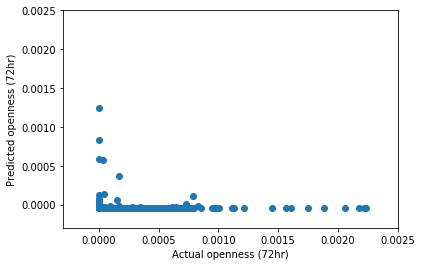

In [229]:
# Evaluation
preds = []
sq_errs = []
relative_errs = []
correct_direction = []
for i in range(len(test_y)):
    pred = float((softplus(tr.dot(tr.tensor(test_x[i]).float(), theta))/100)-4.5418e-5)
    preds.append(float(pred))
    sq_err = (test_y[i] - pred)**2
    sq_errs.append(sq_err)
    relative_err = abs((test_y[i] - pred))/test_y[i] if test_y[i] > 0 else abs((test_y[i] - pred))/(1e-5)
    relative_errs.append(relative_err)
    actual_direction = (test_y[i] - at_r3[i]) > 0
    pred_direction = (pred - at_r3[i]) > 0
    correct_direction.append(1 if actual_direction == pred_direction else 0)

plt.xlabel('Actual openness (72hr)')
plt.ylabel('Predicted openness (72hr)')
plt.xlim([-0.0003, 0.0025])
plt.ylim([-0.0003, 0.0025])
plt.scatter(test_y, preds)
print('sum of squared error:', sum(sq_errs))
print('mean squared error:', sum(sq_errs)/len(test_y))
print('mean, min, max relative error:', sum(relative_errs)/len(test_y), min(relative_errs), max(relative_errs)) # Relative to the actual value
print('direction accuracy:', sum(correct_direction)/len(test_y))

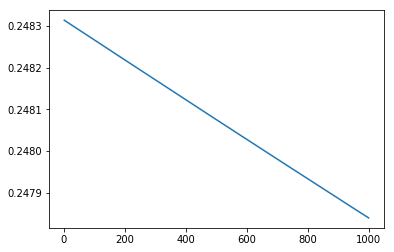

In [220]:
plt.plot(range(1, (len(cost_plot))+1), cost_plot)

# Scratch work

In [221]:
# Representative sequences for each replication
threshold = 0.04
utils.floatvec_to_seq(atP_r1, threshold), utils.floatvec_to_seq(atP_r2, threshold), utils.floatvec_to_seq(atP_r3, threshold)

('--------------T-----T--TA----T------------TA-CAGTCA-TA-T--A-',
 '------------------------------------------------T-A---------',
 '-----T--------T---------AA--------A--T----TACCAGTCA---------')

In [227]:
threshold = 4e-04
utils.floatvec_to_seq(theta[:240], threshold), utils.floatvec_to_seq(theta[240:], threshold)

('-G-G-A-A-G-G-G-A-A-G-G-G-G-A-G-G-G-A-A-A-A-A-G-A-A-G-A-G-A-A', '')

In [224]:
min(theta), max(theta)

(-0.14000768378260373, 0.13991922719388766)

In [71]:
x = []
for rep in [atP_r1, atP_r2, atP_r3]:
    for gene in gene_ids:
        vec = utils.seq_to_vec(promoters[gene])
        #vec = utils.spread_vec(vec)
        x.append(np.append(rep, vec+[1]))
#theta = tr.randn(len(x[0])) # Randomly intialize theta vector
#theta.requires_grad_()

def single_cost(x, y):
    y_est = softplus(max(tr.dot(tr.tensor(x), theta), tr.tensor(-11.8)))/10
    err = y - y_est
    denominator = max(y.data, 9e-6)
    return (err**2)/(1 if denominator == 9e-6 else denominator)
    
costs = [single_cost(train_x[i].float(), train_y[i]).float() for i in range(len(train_x))]
costs = tr.stack(costs)

cost = tr.sum(costs)
cost.backward()
cost, theta.grad

/Users/OliviaFlynn/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


(tensor(3043953.2500, grad_fn=<SumBackward0>),
 tensor([193745.3594, 178441.7188, 134401.9844, 114203.9609, 146080.8594,
         183210.5781, 143699.0312, 147802.4375, 197849.1406, 201927.0781,
         109462.9062, 111553.8828, 133285.1719, 162409.5312, 185273.0781,
         139825.2188, 170113.8750, 183144.9844, 136166.6406, 131367.4688,
         165749.7656, 196530.3594, 121317.9766, 137195.0625, 162856.7500,
         157074.9219, 159313.9062, 141547.5625, 185685.3594, 147643.2344,
         156010.9219, 131453.4531, 156747.4844, 175612.9688, 154917.7188,
         133514.9688, 181193.4531, 131239.5781, 159633.7812, 148725.9531,
         180242.1719, 178963.4531, 126953.7344, 134633.4219, 174927.6250,
         158473.4844, 150964.3906, 136427.6250, 179798.3438, 189864.2812,
         146160.1250, 104970.2969, 167280.3438, 180260.1406, 156582.3594,
         116670.0781, 112149.9297, 272260.8125, 121985.4219, 114396.7891,
         158034.4375, 179503.3281, 143740.7812, 139514.4844, 1757

In [9]:
theta = tr.randn(len(x[0])) # Randomly intialize theta vector
theta.requires_grad_()
cost = tr.sum((tr.tensor(y[0]).float() - softplus(tr.dot(tr.tensor(x[0]).float(),theta)))**2)
print(tr.dot(tr.tensor(x[0]).float(),theta))
cost.backward()
cost, theta.grad

tensor(-7.9145, grad_fn=<DotBackward>)


(tensor(6.3505e-09, grad_fn=<SumBackward0>),
 tensor([-2.2353e-09, -2.1091e-09, -1.4859e-09, -1.2302e-09, -1.6928e-09,
         -2.0124e-09, -1.7302e-09, -1.6252e-09, -2.1403e-09, -2.2804e-09,
         -1.3025e-09, -1.3374e-09, -1.6614e-09, -1.8459e-09, -2.1509e-09,
         -1.4023e-09, -1.8528e-09, -2.0331e-09, -1.4886e-09, -1.6862e-09,
         -1.8934e-09, -2.0474e-09, -1.4080e-09, -1.7119e-09, -1.7984e-09,
         -1.8653e-09, -1.8668e-09, -1.5302e-09, -2.0337e-09, -1.6673e-09,
         -1.7774e-09, -1.5823e-09, -1.7688e-09, -1.7948e-09, -1.8853e-09,
         -1.6118e-09, -2.0012e-09, -1.4188e-09, -1.9527e-09, -1.6880e-09,
         -2.0396e-09, -2.0762e-09, -1.5136e-09, -1.4312e-09, -1.8909e-09,
         -1.8792e-09, -1.8462e-09, -1.4442e-09, -1.9608e-09, -2.2012e-09,
         -1.6237e-09, -1.2750e-09, -1.9891e-09, -1.9996e-09, -1.7273e-09,
         -1.3446e-09, -1.3378e-09, -2.9953e-09, -1.4095e-09, -1.3180e-09,
         -1.9304e-09, -1.9295e-09, -1.6504e-09, -1.5503e-09, -2.064

In [131]:
min([y for y in train_y if y != 0]), max(test_y)

(tensor(9.0000e-06), tensor(0.0022))

In [83]:
train_y

tensor([0.0004, 0.0004, 0.0000,  ..., 0.0001, 0.0000, 0.0009])

In [125]:
tfp.math.softplus_inverse(9e-6)

<tf.Tensor: shape=(), dtype=float32, numpy=-11.618282>

In [58]:
softplus(tr.tensor(0.).float())

tensor(0.6931)

In [54]:
len([0 for pred in preds if pred == 7.510157047363464e-07])

348

In [53]:
min(preds)

7.510157047363464e-07